# Clustering protein structure pairwise searches

We have an all-vs-all protein structure search from foldseek.
We'd like to identify clusters within this search to find families of protein structures.

To do this we'll construct a graph and use graph clustering.
Because we're interested in truncated proteins or merged proteins we'll use a directed graph, where direction is determined by coverage.
If the proteins are both aligned with high coverage, the edge will go in both directions.
If only one or the other is well covered, then the edge will be directed from the high-coverage one to the lower coverage one.
In this way there may be local tree-like structures.
We'll hopefully see this more later.

In [1]:
import pandas as pd
import numpy as np
import igraph as ig
import matplotlib.pyplot as plt

from igraph import Graph
import leidenalg as la

In [2]:
okabe = ['#000000', '#E69F00', '#56B4E9', '#009E73', '#F0E042', '#0072B2', '#D55E00', '#CC79A7', '#999999']

Because the pairwise results are so big, we'll do this chunk by chunk.
Where we're applying the following filters.

- qcov > 0.8
- alntmscore > 0.5
- evalue < 0.001

The TM-score threshold is based on the SCOP documentation, where a TM-score > 0.5 is highly likely to be structurally related.
The query coverage threshold is somewhat arbitrary.
It gives enough room for there to be some missing sequence but it's still a relatively high threshold to give confidence that they are overall the same structure.
Even if these thresholds don't pass, often adjacent nodes can fill in the gaps.

I've saved the graph so that I don't need to reconstruct it.
Honestly, its not really that slow (the saving takes half the time), i just want to be sure i'm using a persistent copy.

In [3]:
G = ig.read("output/alphafold_graph.graphml", format="graphml")

Ok, so we'll look at some descriptive things.

In [4]:
def cluster_to_df(obj):
    return (
        pd.DataFrame({"cluster": obj.membership, "index": np.arange(len(obj.membership)), "id": obj.graph.vs["name"]})
        .sort_values(["cluster", "id"])
        .reset_index(drop=True)
    )

In [5]:
components = G.components()

print(components.modularity)
print(np.unique(components.membership).shape)
cluster_to_df(components).groupby("cluster")["id"].nunique().sort_values(ascending=False).head(10)

0.8360742859340727
(22686,)


cluster
22322    5527
21907    5042
21394    2754
22595    2668
22238    2120
22481    2096
21073    2050
22021    1715
20821    1638
21555    1468
Name: id, dtype: int64

There about 23k components, which is roughly twice the typical number of proteins in a fungal genome.
That's promising. I'd be worried if there were more.

In [6]:
print(
    " N = 1   ", cluster_to_df(components).groupby("cluster")["id"].nunique().sort_values(ascending=False).reset_index().query("id <= 1").shape, "\n",
    "N > 1   ", cluster_to_df(components).groupby("cluster")["id"].nunique().sort_values(ascending=False).reset_index().query("id > 1").shape, "\n",
    "N > 2   ", cluster_to_df(components).groupby("cluster")["id"].nunique().sort_values(ascending=False).reset_index().query("id > 2").shape, "\n",
    "N > 10  ", cluster_to_df(components).groupby("cluster")["id"].nunique().sort_values(ascending=False).reset_index().query("id > 10").shape, "\n",
    "N > 50  ", cluster_to_df(components).groupby("cluster")["id"].nunique().sort_values(ascending=False).reset_index().query("id > 50").shape, "\n",
    "N > 100 ", cluster_to_df(components).groupby("cluster")["id"].nunique().sort_values(ascending=False).reset_index().query("id > 100").shape, "\n",
    "N > 500 ", cluster_to_df(components).groupby("cluster")["id"].nunique().sort_values(ascending=False).reset_index().query("id > 500").shape, "\n",
    "N > 1000", cluster_to_df(components).groupby("cluster")["id"].nunique().sort_values(ascending=False).reset_index().query("id > 1000").shape, "\n",
)

 N = 1    (14371, 2) 
 N > 1    (8315, 2) 
 N > 2    (6190, 2) 
 N > 10   (4164, 2) 
 N > 50   (379, 2) 
 N > 100  (149, 2) 
 N > 500  (24, 2) 
 N > 1000 (13, 2) 



Most of the components are singletons.

In [7]:
components_df = cluster_to_df(components)
components_df.head()

,cluster,index,id
0,0,178783,W9CY62
1,1,178651,W9CX23
2,2,178605,W9CWQ1
3,3,178578,W9CWI2
4,4,178554,W9CWC2


Now let's run a proper clustering algorithm.
Components often have spurious matches joining distinct communities, so we need something to break those links.
We're using the leiden algorithm, which is a modified version of the louvain algorithm that fixes a bug causing clusters joining non-connected components).
We're using the implementation from [leidenalg](https://leidenalg.readthedocs.io) because the default implementation in igraph doesn't support directed graphs.

In [8]:
clusters = la.find_partition(G, la.CPMVertexPartition, resolution_parameter=0.5, n_iterations=-1, weights="alntmscore", seed=666)

In [9]:
print(clusters.modularity)
print(np.unique(clusters.membership).shape)
cluster_to_df(clusters).groupby("cluster")["id"].nunique().sort_values(ascending=False).head(10)

0.4441166755721725
(31412,)


cluster
0    938
1    795
2    737
3    651
4    645
5    635
6    580
7    526
8    505
9    488
Name: id, dtype: int64

In [10]:
print(
    " N = 1   ", cluster_to_df(clusters).groupby("cluster")["id"].nunique().sort_values(ascending=False).reset_index().query("id <= 1").shape, "\n",
    "N > 1   ", cluster_to_df(clusters).groupby("cluster")["id"].nunique().sort_values(ascending=False).reset_index().query("id > 1").shape, "\n",
    "N > 2   ", cluster_to_df(clusters).groupby("cluster")["id"].nunique().sort_values(ascending=False).reset_index().query("id > 2").shape, "\n",
    "N > 10  ", cluster_to_df(clusters).groupby("cluster")["id"].nunique().sort_values(ascending=False).reset_index().query("id > 10").shape, "\n",
    "N > 50  ", cluster_to_df(clusters).groupby("cluster")["id"].nunique().sort_values(ascending=False).reset_index().query("id > 50").shape, "\n",
    "N > 100 ", cluster_to_df(clusters).groupby("cluster")["id"].nunique().sort_values(ascending=False).reset_index().query("id > 100").shape, "\n",
    "N > 500 ", cluster_to_df(clusters).groupby("cluster")["id"].nunique().sort_values(ascending=False).reset_index().query("id > 500").shape, "\n",
    "N > 1000", cluster_to_df(clusters).groupby("cluster")["id"].nunique().sort_values(ascending=False).reset_index().query("id > 1000").shape, "\n",
)

 N = 1    (18286, 2) 
 N > 1    (13126, 2) 
 N > 2    (9013, 2) 
 N > 10   (5129, 2) 
 N > 50   (361, 2) 
 N > 100  (118, 2) 
 N > 500  (9, 2) 
 N > 1000 (0, 2) 



I'd like to find a representative member of each cluster, this is kind of the "average" structure that contains most of the information present in other members.
So if there are multiple domains, we don't want to pick one of the members missing a domain.

Because we filtered for qcov > 0.8 (but no restriction on tcov) I think we should be able to pick the member with the largest sum of in-degree tm-scores.

To focus on within cluster edges, i'll get the subgraph for each cluster.

In [11]:
clusters_df = pd.read_csv("output/clusters.tsv", sep="\t")
clusters_df.head()

,component,component_representative,cluster,representative,id
0,22684,A0A4Z1HP30,833,M7U9J6,A0A023LKZ5
1,22684,A0A4Z1HP30,833,M7U9J6,A0A023LL64
2,22684,A0A4Z1HP30,3832,A0A384JXV5,A0A023LLX4
3,22684,A0A4Z1HP30,157,A0A4Z1GQJ1,A0A1D9PZ51
4,22684,A0A4Z1HP30,5687,A0A4Y8CRW7,A0A1D9Q150


Ok. We have lists of clusters that we can look at later.
I'll have a quick look at how these graphs look.

In [12]:
def get_subgraph(clusters, cluster_ids: list[int] = None, ids: list[str] = None):
    clusters_df = cluster_to_df(clusters)

    sg_ids = set()
    if cluster_ids is not None:
        sg_ids.update(clusters_df.loc[clusters_df["cluster"].isin(cluster_ids), "index"])
    if ids is not None:
        sg_ids.update(clusters_df.loc[clusters_df["id"].isin(ids), "index"])

    return clusters.graph.subgraph(sg_ids)

In [13]:
clusters_df.groupby("cluster")["id"].nunique().sort_values(ascending=False)[200:300]

cluster
203    71
206    71
201    71
199    71
198    71
       ..
296    56
297    56
289    56
305    55
303    55
Name: id, Length: 100, dtype: int64

In [14]:
Gsub = get_subgraph(clusters, cluster_ids=[296])

In [15]:
layout = Gsub.layout(layout='drl')

<Axes: >

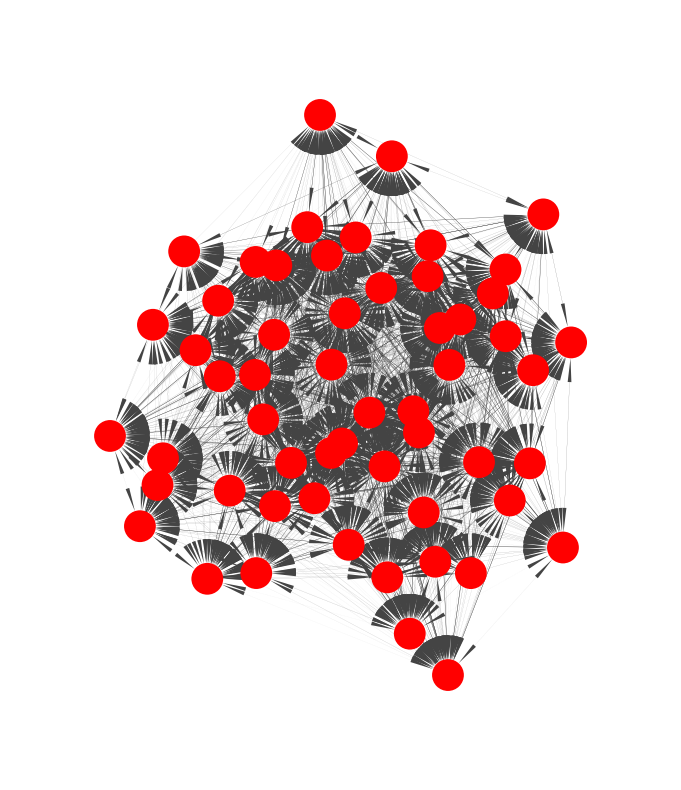

In [16]:
weights = [np.log((1 - x) + 1) * 2 for x in Gsub.es.get_attribute_values("qcov")]

fig, ax = plt.subplots(figsize=(10, 10))
ig.plot(
    Gsub,
    layout=layout,
    vertex_size=0.1,
    edge_width=weights,
    edge_arrow_width=0.25,
    edge_arrow_size=0.005,
    edge_vertex_frame_color=None,
    vertex_frame_width=0,
    target=ax,
    autocurve=False
)

<Axes: >

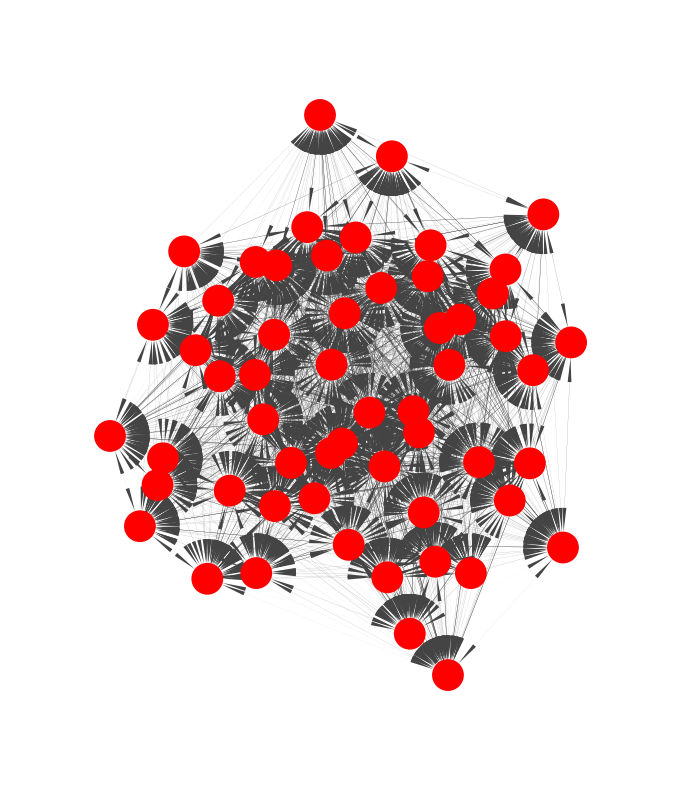

In [17]:
weights = [np.log((1 - x) + 1) * 2 for x in Gsub.es.get_attribute_values("tcov")]

fig, ax = plt.subplots(figsize=(10, 10))
ig.plot(
    Gsub,
    layout=layout,
    vertex_size=0.1,
    edge_width=weights,
    edge_arrow_width=0.25,
    edge_arrow_size=0.005,
    edge_vertex_frame_color=None,
    vertex_frame_width=0,
    target=ax,
    autocurve=False
)

I think we'll revisit these once we've got functional information.